In [7]:
# Install this, for some reason, google colab doesn't have this on their dependencies.
!pip install pylint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.3/275.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 7.7 MB/s eta 0:00:00


# Imports

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import re
from io import BytesIO
from tokenize import tokenize, COMMENT, NL
import pickle
import pylint
import subprocess
import os
import tempfile
import timeit
import sys
import ast

# Dataset for Code Readability

https://www.kaggle.com/datasets/paakhim10/code-snippets-insights-and-readability

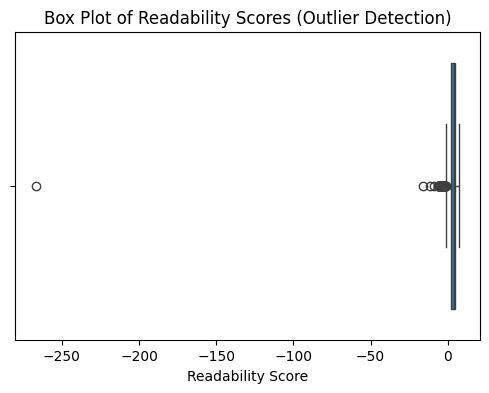

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_temp = pd.read_csv('data_python.csv')

# Plot boxplot to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_temp['readability'])
plt.title("Box Plot of Readability Scores (Outlier Detection)")
plt.xlabel("Readability Score")
plt.show()


### Removing the Outliers

Outliers removed: 65


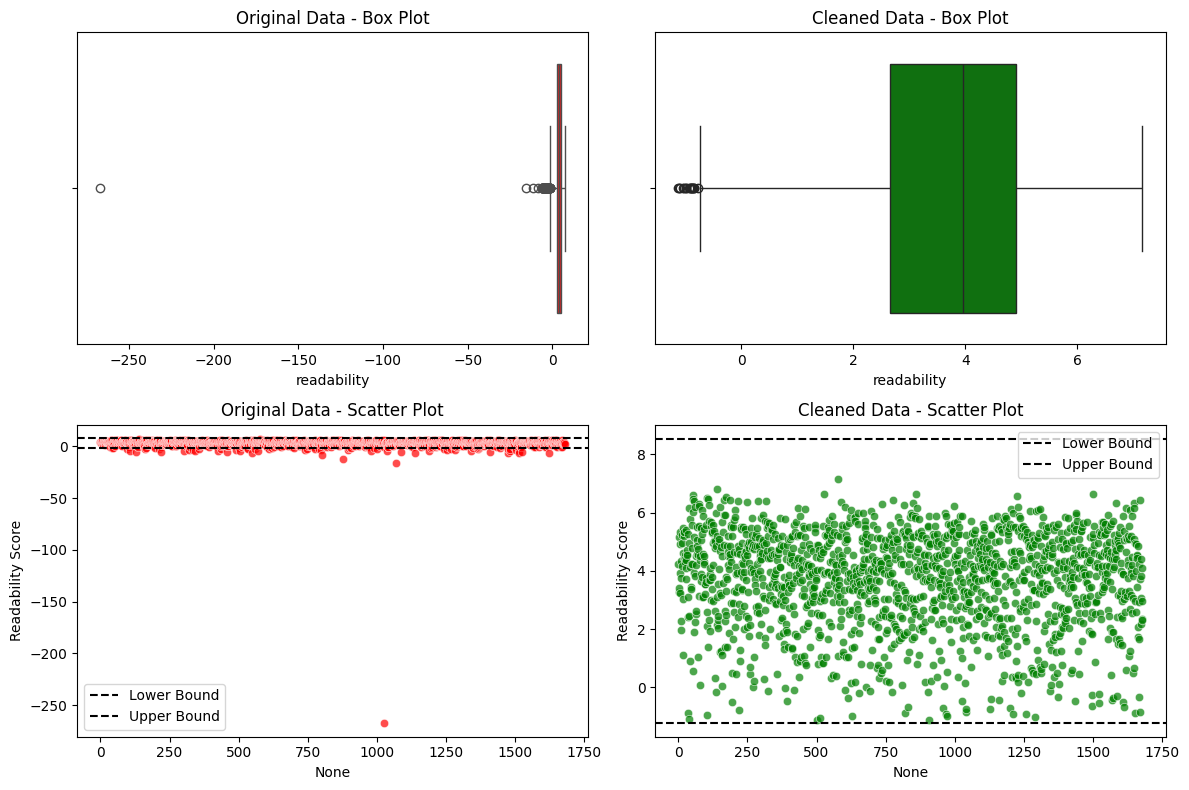

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_temp = pd.read_csv('data_python.csv')

# Calculate IQR
Q1 = df_temp['readability'].quantile(0.25)
Q3 = df_temp['readability'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_clean = df_temp[(df_temp['readability'] >= lower_bound) & (df_temp['readability'] <= upper_bound)]

# Count and print removed outliers
num_outliers = len(df_temp) - len(df_clean)
print(f"Outliers removed: {num_outliers}")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original Box Plot
sns.boxplot(x=df_temp['readability'], ax=axes[0, 0], color="red")
axes[0, 0].set_title("Original Data - Box Plot")

# Cleaned Box Plot
sns.boxplot(x=df_clean['readability'], ax=axes[0, 1], color="green")
axes[0, 1].set_title("Cleaned Data - Box Plot")

# Original Scatter Plot
sns.scatterplot(x=df_temp.index, y=df_temp['readability'], ax=axes[1, 0], color="red", alpha=0.7)
axes[1, 0].set_title("Original Data - Scatter Plot")
axes[1, 0].set_ylabel("Readability Score")
axes[1, 0].axhline(y=lower_bound, color='black', linestyle='--', label="Lower Bound")
axes[1, 0].axhline(y=upper_bound, color='black', linestyle='--', label="Upper Bound")
axes[1, 0].legend()

# Cleaned Scatter Plot
sns.scatterplot(x=df_clean.index, y=df_clean['readability'], ax=axes[1, 1], color="green", alpha=0.7)
axes[1, 1].set_title("Cleaned Data - Scatter Plot")
axes[1, 1].set_ylabel("Readability Score")
axes[1, 1].axhline(y=lower_bound, color='black', linestyle='--', label="Lower Bound")
axes[1, 1].axhline(y=upper_bound, color='black', linestyle='--', label="Upper Bound")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [68]:
# load original dataset that was gathered for Phaaki
df_temp = pd.read_csv('data_python_cleaned.csv')

# remove other non-needed columns
df_temp = df_temp[['python_solutions', 'readability']]

# change readability to binary
df_temp['label'] = (df_temp['readability'] > 2.4).astype(int) #2.4 as the most reasonable threshold

# remove main readability column
df_temp = df_temp[['python_solutions', 'label']]

# extract python codes "python_solution" and labels
code_snippets = df_temp['python_solutions'].astype(str).tolist()
labels = df_temp['label'].values

# export incomplete data for code generating
fixed_file_path = "data_python_incomplete.csv"
df_temp.to_csv(fixed_file_path, index=False)

### Import the Python Complete from Code Generator

In [69]:
# load complete data
df = pd.read_csv('data_python_complete.csv')

# keep important columns
df = df[['python_solutions', 'label']]

# check if labels are 0 and 1
df['label'] = df['label'].astype(int)

# extract python codes and labels
pycode = df['python_solutions'].astype(str).tolist()
labels = df['label'].values

In [70]:
df.head()

,python_solutions,label
0,"class Solution:\n def twoSum(self, nums: Li...",1
1,class Solution:\n def lengthOfLongestSubstr...,1
2,class Solution:\n def findMedianSortedArray...,1
3,class Solution:\n def longestPalindrome(sel...,1
4,"class Solution:\n def convert(self, s: str,...",1


### Data Checking without Tokenization

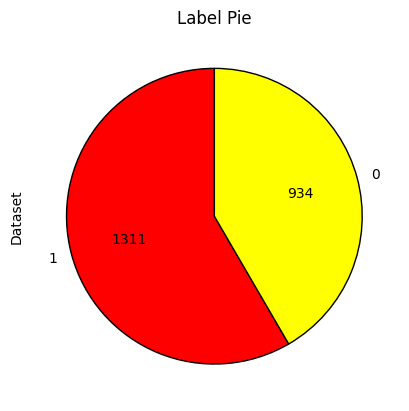

In [71]:
label_counts = df['label'].value_counts()

label_counts.plot(
    kind='pie',
    title="Label Pie",
    ylabel='Dataset',
    autopct=lambda p: f'{int(p * sum(label_counts) / 100)}',
    colors=['red', 'yellow'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.show()


###  Tokenization

In [72]:
def clean_python_code(code):
    if not isinstance(code, str) or len(code.strip()) == 0:
        return "EMPTY_CODE"

    code = code.replace('\t', '    ')
    code = re.sub(r'#.*', '', code)
    code = re.sub(r'""".*?"""|\'\'\'.*?\'\'\'', '', code, flags=re.DOTALL)
    code = re.sub(r'(\b(if|for|while|def|class)\b[^\n]*)(?<!:)\n', r'\1:\n', code)
    code = re.sub(r'(\b(def|class)\b[^\n]*:)(\n\s*\n)', r'\1\n    pass\n', code)

    code = re.sub(r'\s*([,:\])}])', r'\1', code)
    code = re.sub(r'([{[(])\s*', r'\1', code)

    return code.strip()

# apply function to dataset muna
df['clean_python_solutions'] = df['python_solutions'].apply(clean_python_code)

df = df.drop_duplicates(subset=['clean_python_solutions'], keep='first')
df = df[df['clean_python_solutions'] != "EMPTY_CODE"]
df = df.reset_index(drop=True)
df['clean_python_solutions'] = df['python_solutions'].apply(clean_python_code)

In [73]:
print(df[['python_solutions', 'clean_python_solutions']].head(10))

                                    python_solutions  \
0  class Solution:\n    def twoSum(self, nums: Li...   
1  class Solution:\n    def lengthOfLongestSubstr...   
2  class Solution:\n    def findMedianSortedArray...   
3  class Solution:\n    def longestPalindrome(sel...   
4  class Solution:\n    def convert(self, s: str,...   
5  class Solution:\n    def reverse(self, x: int)...   
6  class Solution:\n    def myAtoi(self, s: str) ...   
7  class Solution:\n    def isPalindrome(self, x:...   
8  class Solution:\n    @lru_cache\n    def isMat...   
9  class Solution:\n    def maxArea(self, height:...   

                              clean_python_solutions  
0  class Solution:\n    def twoSum(self, nums: Li...  
1  class Solution:\n    def lengthOfLongestSubstr...  
2  class Solution:\n    def findMedianSortedArray...  
3  class Solution:\n    def longestPalindrome(sel...  
4  class Solution:\n    def convert(self, s: str,...  
5  class Solution:\n    def reverse(self, x: int)... 

### Data Checking with Tokenization

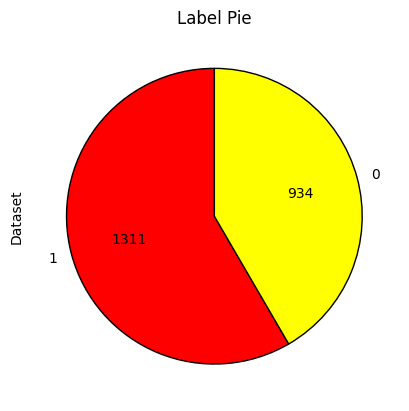

In [74]:
label_counts = df['label'].value_counts()

label_counts.plot(
    kind='pie',
    title="Label Pie",
    ylabel='Dataset',
    autopct=lambda p: f'{int(p * sum(label_counts) / 100)}',
    colors=['red', 'yellow'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.show()


### More Tokenizing

In [75]:
# Tokenize
max_vocab_size = 5000
max_length = 500

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_python_solutions'])
sequences = tokenizer.texts_to_sequences(df['clean_python_solutions'])

X = pad_sequences(sequences, maxlen=max_length, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, random_state=42)

### Last Checking of Data with Finalized Tokenizing

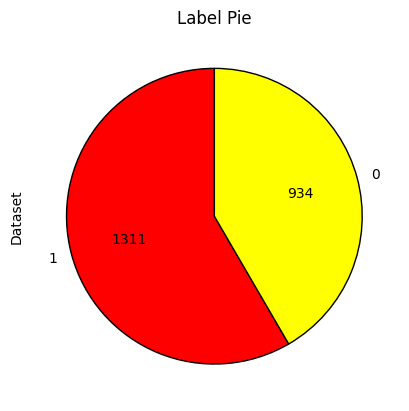

In [76]:
label_counts = df['label'].value_counts()

label_counts.plot(
    kind='pie',
    title="Label Pie",
    ylabel='Dataset',
    autopct=lambda p: f'{int(p * sum(label_counts) / 100)}',
    colors=['red', 'yellow'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.show()


### Creating the CNN Model for Code Readability

This one is important because it is needed said in the instructions

In [77]:
def create_cnn_model(filters=32):# increase filter by 64 of 16 for tweaking
    inputs = Input(shape=(max_length,), name='cnn_input')
    x = Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length)(inputs)
    x = Conv1D(filters=filters, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=filters * 2, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)# increase L2 for tweaking
    x = Dropout(0.4)(x)# increase or decrease dropout for tweaking
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output_layer)
    return model

# creating the model
model = create_cnn_model()

# Adam Optimizer with Exponential Decay
lr_schedule = ExponentialDecay(initial_learning_rate=0.0003, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

# compiling
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [78]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)               │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 500, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 498, 32)             │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 249, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 247, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,007,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,666,401 (6.36 MB)

 Trainable params: 1,666,401 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Code Readability

In [79]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print(df['label'].value_counts())

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

model.save("CRModel.keras")

label
1    1312
0     935
Name: count, dtype: int64
Class Weights: {0: 1.1806833114323259, 1: 0.8672779922779923}
Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.7030 - loss: 2.3469 - val_accuracy: 0.8689 - val_loss: 0.7002
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8524 - loss: 0.6401 - val_accuracy: 0.8867 - val_loss: 0.4050
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9022 - loss: 0.3624 - val_accuracy: 0.8844 - val_loss: 0.3392
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9181 - loss: 0.2700 - val_accuracy: 0.8956 - val_loss: 0.3266
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9356 - loss: 0.2402 - val_accuracy: 0.8711 - val_loss: 0.3501
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9449 - loss: 0.1923 - val_accuracy: 0.8978 - val_loss: 0.3468
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.9654 - loss: 0.1377 - val_accuracy: 0.8422 - val_loss: 

### Tokenizer saving

In [80]:
# Save the tokenizer to a file
tokenizer_path = "/content/python_tokenizer.pkl"  # Colab
with open(tokenizer_path, "wb") as handle:
    pickle.dump(tokenizer, handle)

print(f"Tokenizer saved at {tokenizer_path}")

Tokenizer saved at /content/python_tokenizer.pkl


### Accuracy Checking

In [81]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print final accuracy and loss
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8885 - loss: 0.3432

Final Test Accuracy: 0.8956
Final Test Loss: 0.3266


### Data Checking for Readable data and Predicted data

In [82]:
#Readable data
actual_readable = (df['label'] == 1).sum()
actual_unreadable = (df['label'] == 0).sum()
print(f"Actual Readable: {actual_readable}/{len(df)}")
print(f"Actual Unreadable: {actual_unreadable}/{len(df)}")

# Get predictions for ALL data, not just X_test
predictions = model.predict(X)  # Use full dataset `X`

# Convert predictions to binary (readable/unreadable)
pred_labels = (predictions > 0.5).astype(int).flatten()

# Count predicted values
readable_count = (pred_labels == 1).sum()
unreadable_count = (pred_labels == 0).sum()

# Print results
print(f"\nPredicted Readable: {readable_count}/{len(X)}")
print(f"Predicted Unreadable: {unreadable_count}/{len(X)}")

Actual Readable: 1312/2247
Actual Unreadable: 935/2247
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step

Predicted Readable: 1323/2247
Predicted Unreadable: 924/2247


### Confusion Matrix and Evaluation Metrics

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8885 - loss: 0.3432

Final Test Accuracy: 0.8956
Final Test Loss: 0.3266

Actual Readable: 1312/2247
Actual Unreadable: 935/2247
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

Predicted Readable: 1323/2247
Predicted Unreadable: 924/2247
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Evaluation Metrics (Test Data):
Accuracy: 0.8956
Precision: 0.9164
Recall: 0.9130
F1 Score: 0.9147
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87       174
           1       0.92      0.91      0.91       276

    accuracy                           0.90       450
   macro avg       0.89      0.89      0.89       450
weighted avg       0.90      0.90      0.90       450



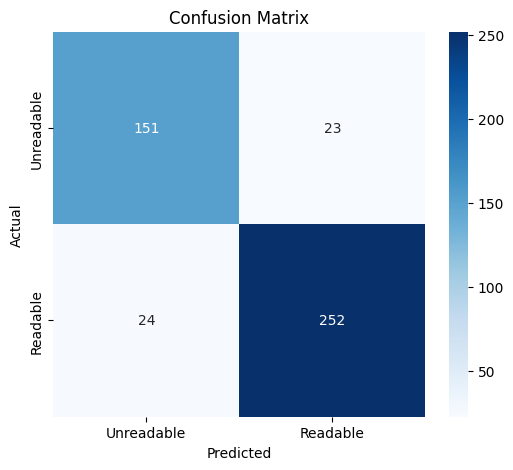

In [83]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print final accuracy and loss
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

# Count actual labels in the entire dataset
actual_readable = (df['label'] == 1).sum()
actual_unreadable = (df['label'] == 0).sum()
print(f"\nActual Readable: {actual_readable}/{len(df)}")
print(f"Actual Unreadable: {actual_unreadable}/{len(df)}")

# Get predictions for ALL data, not just X_test
predictions = model.predict(X)  # Use full dataset `X`

# Convert predictions to binary (readable/unreadable)
pred_labels = (predictions > 0.5).astype(int).flatten()

# Count predicted values
readable_count = (pred_labels == 1).sum()
unreadable_count = (pred_labels == 0).sum()

# Print results
print(f"\nPredicted Readable: {readable_count}/{len(X)}")
print(f"Predicted Unreadable: {unreadable_count}/{len(X)}")

# Generate confusion matrix based on test data
conf_matrix = confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype(int).flatten())

# Compute evaluation metrics (using test data)
accuracy = accuracy_score(y_test, (model.predict(X_test) > 0.5).astype(int).flatten())
precision = precision_score(y_test, (model.predict(X_test) > 0.5).astype(int).flatten())
recall = recall_score(y_test, (model.predict(X_test) > 0.5).astype(int).flatten())
f1 = f1_score(y_test, (model.predict(X_test) > 0.5).astype(int).flatten())

# Print evaluation metrics
print("\nEvaluation Metrics (Test Data):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, (model.predict(X_test) > 0.5).astype(int).flatten()))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Unreadable", "Readable"], yticklabels=["Unreadable", "Readable"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Labeling and Checking

In [84]:
df['pred_label'] = pred_labels  # Add predictions to DataFrame
df['correct'] = (df['pred_label'] == df['label']).astype(int)

# Show some misclassified samples
misclassified = df[df['correct'] == 0]
print(misclassified[['python_solutions', 'label', 'pred_label']].head(10))

                                      python_solutions  label  pred_label
8    class Solution:\n    @lru_cache\n    def isMat...      0           1
10   class Solution:\n    def intToRoman(self, num:...      0           1
85   class Solution:\n    def numIslands(self, grid...      1           0
101  class Solution:\n    def containsNearbyAlmostD...      0           1
102  class Solution:\n    def maximalSquare(self, m...      1           0
105  class Solution:\n    def calculate(self, s: st...      0           1
107  class Solution:\n    def majorityElement(self,...      0           1
128  class Solution:\n    def numSquares(self, n: i...      1           0
134  class Solution:\n    def canWinNim(self, n: in...      1           0
138  class Solution:\n    def isAdditiveNumber(self...      0           1


### Determining the Prediction for Code Readability

In [85]:
def predict_readability(python_code):

    # Ensure tokenizer is loaded
    global tokenizer
    if tokenizer is None:
        print("Error: Tokenizer is not initialized.")
        return "Tokenizer is missing. Please train the model first."

    # Clean the input code snippet (ensure clean_code() is defined)
    cleaned_python_code = clean_python_code(python_code)

    # Tokenize and pad sequence
    sequence = tokenizer.texts_to_sequences([cleaned_python_code])
    padded_sequence = pad_sequences(sequence, maxlen=500, padding='post')

    # Predict readability (Make sure the model expects 3 inputs)
    prediction = model.predict([padded_sequence])
    score = prediction[0][0]  # Extract predicted score

    # Determine readability
    if score > 0.5:
        message = "✅READABLE"
    else:
        message = "❌UNREADABLE"

    return message

### Sample Readable Code

In [86]:
sample_readable = df[df['label'] == 1].sample(1)['python_solutions'].values[0]
print("Sample Readable Code:\n", sample_readable)
print(predict_readability(sample_readable))

Sample Readable Code:
 class Solution:
    def maxSlidingWindow(self, nums: List[int], k: int) -> List[int]:
        l,r = 0,0
        q = []
        
        while True:
            if not q:
                q.append(nums[l])
            else:
                while q and nums[r]>=q[-1]:
                    q.pop()
                q.append(nums[r])         
            if r-l+1==k:
                break
            r+=1
          
        ans = []
        
        while r!=len(nums):
            maxi = q[0]
            ans.append(maxi)	
            if r+1<len(nums):
                while q and (len(q)==0 or nums[r+1]>q[-1]):
                    q.pop()
                q.append(nums[r+1])  
            if nums[l]==q[0]:
                q.pop(0)
            l+=1
            r+=1
        return ans
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
✅READABLE


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: cnn_input
Received: inputs=('Tensor(shape=(1, 500))',)
  warnings.warn(msg)


### Sample Unreadable Code

In [89]:
sample_unreadable = df[df['label'] == 0].sample(1)['python_solutions'].values[0]
print("Sample Unreadable Code:\n", sample_unreadable)
print(predict_readability(sample_unreadable))

Sample Unreadable Code:
 divide = lambda var40: var40 / 0
print(divide(28))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
❌UNREADABLE


### Code Readability Testing with User Input

In [88]:
readable_code = """
asdasdasdasdfffffasdasd
"""

print(predict_readability(readable_code))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
❌UNREADABLE


# Bug Localization


In [90]:
# checking bugs using the pylint lib .txt saving
def check_bugs(code, temp_file_path, output_filename="bug_report.txt"):
    if not code:
        return "No code extracted."
    result = subprocess.run(["pylint", "--disable=all", "--enable=E,F", temp_file_path],
                            capture_output=True, text=True, check=False)

    os.remove(temp_file_path)
    return f"\nBug report saved at \n{result.stdout}"

# temp
def temp_file(code):
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".py", mode="w")
    temp_file.write(code)
    temp_file_path = temp_file.name
    temp_file.close()
    return temp_file_path

In [91]:
# model loading
def load_model_and_tokenizer():
    global model, tokenizer
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(TOKENIZER_PATH, "rb") as handle:
        tokenizer = pickle.load(handle)

In [92]:
import ast

# Readability Prediction Function
def predict_readability(code_snippet):
    # Check for syntax errors first
    try:
        ast.parse(code_snippet)  # Try parsing the code
    except SyntaxError:
        return "❌UNREADABLE❌"  # If it can't be parsed, it's unreadable

    # Try executing the code to check if it's functional
    try:
        exec(code_snippet, {}, {})  # Run code in an isolated scope
    except Exception:  # Catch any runtime errors
        return "❌UNREADABLE❌"

    return "✅READABLE✅"  # If execution succeeds, it's readable


In [93]:
# Bug Detection using Pylint
def check_bugs(code):
    """Run pylint on the provided code snippet and return formatted results."""
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".py", mode="w") as temp_file:
            temp_file.write(code)
            temp_file_path = temp_file.name

        result = subprocess.run([
            "pylint", "--disable=all", "--enable=E,F", temp_file_path
        ], capture_output=True, text=True, check=False)

        os.remove(temp_file_path)
        output = result.stdout.strip()

        if "E" in output or "F" in output:
            return f"❌ Bugs Found:\n{output}"
        else:
            return "✅ Code is clean! No major issues detected."

    except FileNotFoundError:
        return "⚠️ Pylint is missing! Install it with: `pip install pylint`."
    except Exception as e:
        return f"⚠️ Error running Pylint: {str(e)}"


In [94]:
# Time & Space Complexity Analysis
def measure_complexity(code):
    exec_globals = {}
    indented_code = "\n    ".join(code.splitlines())
    wrapped_code = f"def temp_function():\n    {indented_code}"
    try:
        exec(wrapped_code, exec_globals)
        temp_function = exec_globals["temp_function"]
        execution_time = timeit.timeit(temp_function, number=1000)
        memory_usage = sys.getsizeof(temp_function)
        return f" Execution Time: {execution_time:.6f} sec\n Memory Usage: {memory_usage} bytes"
    except Exception as e:
        return f"⚠️ Error in complexity analysis: {str(e)}"

In [95]:
# Driver function
def analyze_code(code_snippet):
    print("\n Bug Detection:")
    print(check_bugs(code_snippet))

    print("\n Readability Analysis:")
    print(predict_readability(code_snippet))

    print("\n Time & Space Complexity:")
    print(measure_complexity(code_snippet))

In [96]:
# Load the trained model and tokenizer
MODEL_PATH = "CRModel.keras"
TOKENIZER_PATH = "python_tokenizer.pkl"

In [97]:
# Example Code Snippet for Testing
example_code = """
class Solution:
    def countSegments(self, s: str) -> int:
        count = 0
        for i in range(len(s)):
            if s[i] != " " and (i==0 or s[i-1]== " "):
                count+=1

        return count
"""

# Load model & tokenizer, then analyze the code snippet
load_model_and_tokenizer()
analyze_code(example_code)


 Bug Detection:
✅ Code is clean! No major issues detected.

 Readability Analysis:
✅READABLE✅

 Time & Space Complexity:
 Execution Time: 0.012795 sec
 Memory Usage: 152 bytes
